# Customer Lifetime Value

Lifetime value (LTV) is a metric that estimates the total revenue a business can expect to generate from a customer throughout their entire relationship with the company. It accounts for the customer's revenue contribution, purchase frequency, retention rate, and average lifespan as a customer. Forecasting LTV is valuable because it helps businesses make data-driven decisions about customer acquisition, retention strategies, and marketing spend. By understanding the projected value of a customer, companies can determine how much to invest in acquiring and retaining customers while maximizing profitability. LTV also provides insights into customer segmentation, helping businesses identify their most valuable customer groups and tailor strategies accordingly.

There are various ways to calculate LTV, each of which has its merits and drawbacks. In this notebook, we'll explore three common methods:
1. Average Method
2. Cohort Method
3. BG/NBD Method

## Importing Libraries and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# read_excel requires openpyxl
df = pd.read_excel('ltv_dataset.xlsx', parse_dates=['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [4]:
print(f"Number of transactions: {df.shape[0]}")

Number of transactions: 541909


## Preprocessing

Our dataset is a record of all transactions occuring between Dec 1, 2010 and Dec 9, 2011 for a UK-based business. The business primarily sells all-occasion gifts, mostly wholesale to downstream retail locations. Each row of the dataset is a line item on an invoice.

Our dataset has the following features:
- `InvoiceNo`: a 6-digit number that represents the invoice the line item appears on
- `StockCode`: a unique ID that represents the item/SKU that was sold
- `Description`: the name of the item
- `Quantity`: how many of the item were sold on that invoice
- `InvoiceData`: the date and time of the invoice/transaction
- `UnitPrice`: the unit price of the line item
- `CustomerID`: a unique ID that represents the customer making the purchase
- `Country`: the country that the customer resides in

Our forecasting doesn't need all of these features. That is, some of these features are irrelevant for our use case. We only need `CustomerID`, `InvoiceNo`, `InvoiceDate`, `Quantity`, and `UnitPrice`. Let's select those features and drop the others. Additionally, we'll need a `TotalSales` feature that calculates the total cost of each line item.

In [5]:
# Drop unneeded features
features = ['CustomerID', 'InvoiceDate', 'InvoiceNo', 'Quantity', 'UnitPrice']
ltv_features = df[features].copy() # Copy so we don't change the original df
ltv_features['TotalSales'] = ltv_features['Quantity'] * ltv_features['UnitPrice']
ltv_features.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalSales
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


In [6]:
ltv_features.describe()

,CustomerID,InvoiceDate,Quantity,UnitPrice,TotalSales
count,406829.000000,541909,541909.000000,541909.000000,541909.000000
mean,15287.690570,2011-07-04 13:34:57.156386048,9.552250,4.611114,17.987795
min,12346.000000,2010-12-01 08:26:00,-80995.000000,-11062.060000,-168469.600000
25%,13953.000000,2011-03-28 11:34:00,1.000000,1.250000,3.400000
50%,15152.000000,2011-07-19 17:17:00,3.000000,2.080000,9.750000
75%,16791.000000,2011-10-19 11:27:00,10.000000,4.130000,17.400000
max,18287.000000,2011-12-09 12:50:00,80995.000000,38970.000000,168469.600000
std,1713.600303,NaN,218.081158,96.759853,378.810824


### Negative Values

Looking at the stats for each column, we notice some issues. `Quantity`, `UnitPrice`, and `TotalSales` all have some negative values in them. In this dataset, those negative values represent returns, where the customer returned the products. In LTV estimates we're only interested in the total value a customer will generate over their lifetime, so we can safely drop negative values here.

In [7]:
ltv_features = ltv_features[ltv_features['TotalSales'] > 0]
ltv_features.describe()

,CustomerID,InvoiceDate,Quantity,UnitPrice,TotalSales
count,397884.000000,530104,530104.000000,530104.000000,530104.000000
mean,15294.423453,2011-07-04 20:16:05.225087744,10.542037,3.907625,20.121871
min,12346.000000,2010-12-01 08:26:00,1.000000,0.001000,0.001000
25%,13969.000000,2011-03-28 12:22:00,1.000000,1.250000,3.750000
50%,15159.000000,2011-07-20 12:58:00,3.000000,2.080000,9.900000
75%,16795.000000,2011-10-19 12:39:00,10.000000,4.130000,17.700000
max,18287.000000,2011-12-09 12:50:00,80995.000000,13541.330000,168469.600000
std,1713.141560,NaN,155.524124,35.915681,270.356743


### NaN Values

Let's check for NaN values and address them as needed.

In [8]:
# Check for NaN values
null_count = ltv_features.isnull().sum()
print(f"Count of null values:\n{null_count}")
for feature, count in null_count.items():
    if count > 0:
        print(f"Feature {feature} has {count/len(ltv_features)*100:.2f}% null values")

Count of null values:
CustomerID     132220
InvoiceDate         0
InvoiceNo           0
Quantity            0
UnitPrice           0
TotalSales          0
dtype: int64
Feature CustomerID has 24.94% null values


This presents a problem. Almost 25% of `CustomerID` values are missing. Due to the nominal nature of unique IDs, it's logically inconsistent to impute data to fill missing values. There is no relation between an ID of 13969 and one of 18287, so imputing data doesn't make sense. In a real world scenaraio, the best thing to do here would be to search for these invoices in an upstream software and correct add `CustomerID`s whenever they are found. In our case, we'll just drop rows with missing `CustomerID`s.

In [9]:
ltv_features = ltv_features.dropna()
null_count = ltv_features.isnull().sum()
print(f"Count of null values:\n{null_count}")
for feature, count in null_count.items():
    if count > 0:
        print(f"Feature {feature} has {count/len(ltv_features)*100:.2f}% null values")

Count of null values:
CustomerID     0
InvoiceDate    0
InvoiceNo      0
Quantity       0
UnitPrice      0
TotalSales     0
dtype: int64


## Average Method

The simplest way of computing LTV is the average method. The average method assumes a constant sample-wide average spend and churn rate, and produces a single LTV estimate that pertains to all customers.

The calculation is $LTV = ((Average Sales \times Purchase Frequency) \div Churn Rate) \times Profit Margin$,\
where \
$Average Sales = Total Sales \div Total Order Count$\
$Purchase Frequency = Total Order Count \div Unique Customer Count$\
$Churn Rate = 1 - (Repeat Customer Count \div Unique Customer Count)$\
$Profit Margin = Constant Based On Business Context$

For our use case, we'll assume a 30% profit margin, based on a 2024 IbisWorld report.\
The average method requires data to be formatted at the customer level, rather than the transaction level, so we'll need to reformat our data a bit.

### Prepping the Data

In [10]:
# Transaction level -> Customer level
# Group by CustomerID, then calculate days between first and last purchase, number of purchases, and total sales
customer_level = ltv_features.groupby('CustomerID').agg({'InvoiceDate': lambda x: (x.max() - x.min()).days,
                                                         'InvoiceNo': lambda x: len(x),
                                                         'TotalSales': lambda x: sum(x)})
customer_level.columns = ['CustomerAge', 'PurchaseFrequency', 'TotalSales']
customer_level.head()

,CustomerAge,PurchaseFrequency,TotalSales
CustomerID,,,
12346.0,0,1,77183.60
12347.0,365,182,4310.00
12348.0,282,31,1797.24
12349.0,0,73,1757.55
12350.0,0,17,334.40


In [11]:
customer_level.describe()

,CustomerAge,PurchaseFrequency,TotalSales
count,4338.000000,4338.000000,4338.000000
mean,130.448594,91.720609,2054.266460
std,132.039554,228.785094,8989.230441
min,0.000000,1.000000,3.750000
25%,0.000000,17.000000,307.415000
50%,92.500000,41.000000,674.485000
75%,251.750000,100.000000,1661.740000
max,373.000000,7847.000000,280206.020000


### Calculate Average LTV

In [12]:
# Calculate average sales per purchase, purchase frequency, and churn rate
average_sales = round(np.mean(customer_level['TotalSales']), 4)
purchase_frequency = round(np.mean(customer_level['PurchaseFrequency']), 4)
repeat_customer_count = customer_level[customer_level['PurchaseFrequency'] > 1].shape[0]
churn_rate = round(1 - (repeat_customer_count / customer_level.shape[0]), 4)

# Calculate LTV
profit_margin = 0.3
LTV = round((average_sales * purchase_frequency / churn_rate) * profit_margin, 2)
print(f"Calculation: (({average_sales} * {purchase_frequency}) / {churn_rate}) * {profit_margin}")
print(f"Average LTV: ${LTV:,}")

Calculation: ((2054.2665 * 91.7206) / 0.0164) * 0.3
Average LTV: $3,446,680.9


### Limitations

Consider the predicted LTV: $3.45 million. Does that feel reasonable? I don't believe so. Look at the stats for the `customer_level[TotalSales]` column. 75% of customers generated total revenue of less than $1661 (that is, the 75th percentile of customers have spent about $1661 so far.) The standard deviaion of `TotalSales` is a whopping $8989, which indicates a huge degree of spread in the underlying data. If we visualize the distribution of total sales, we can see that is indeed the case.

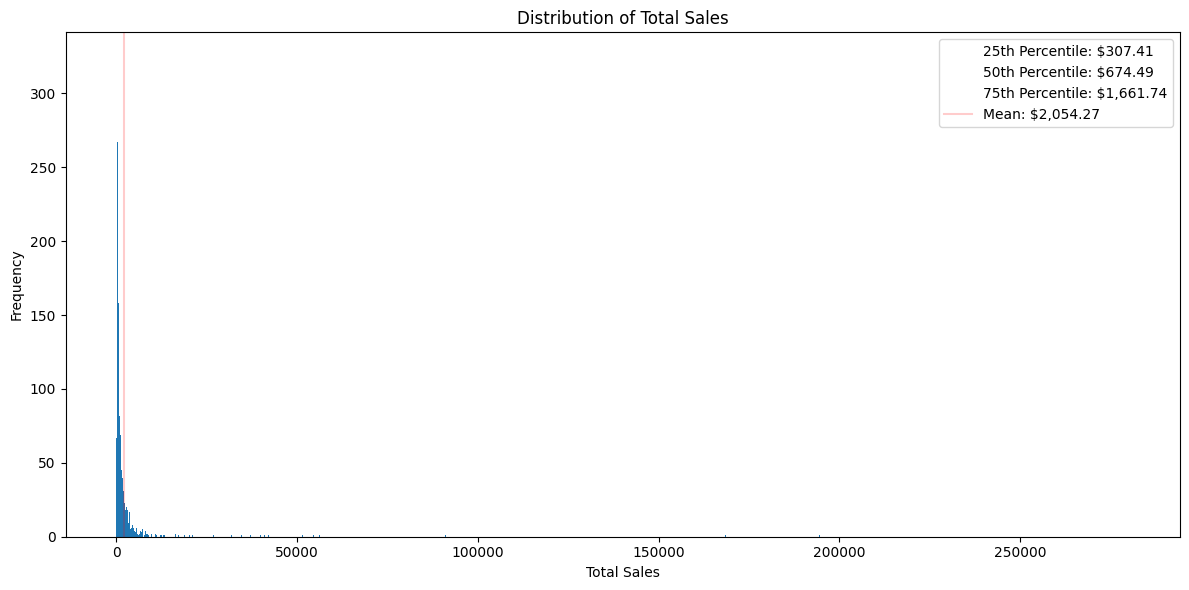

In [13]:
# Calculate mean, standard deviation, and quartiles
mean_ts = customer_level['TotalSales'].mean()
std_ts = customer_level['TotalSales'].std()
quartiles_ts = customer_level['TotalSales'].quantile([0.25, 0.5, 0.75])

# Plot the distribution
plt.figure(figsize=(12, 6))
plt.hist(customer_level['TotalSales'], bins=len(customer_level))
plt.title('Distribution of Total Sales')
plt.xlabel('Total Sales')
plt.ylabel('Frequency')

# Plot quartiles
for q, value in quartiles_ts.items():
    plt.axvline(value, color='purple', linestyle='--', label=f'{int(q*100)}th Percentile: ${value:,.2f}', alpha=0)

# Plot mean
plt.axvline(mean_ts, color='red', linestyle='-', label=f'Mean: ${mean_ts:,.2f}', alpha=0.2)

plt.legend()
plt.tight_layout()
plt.show()

Clearly, the vast majority of customers have a `TotalSales` value below $1,000. The distribution is right-skewed, with a long tail of high-value customers. We can see this high-value customers if we adjust the y-axis scale.

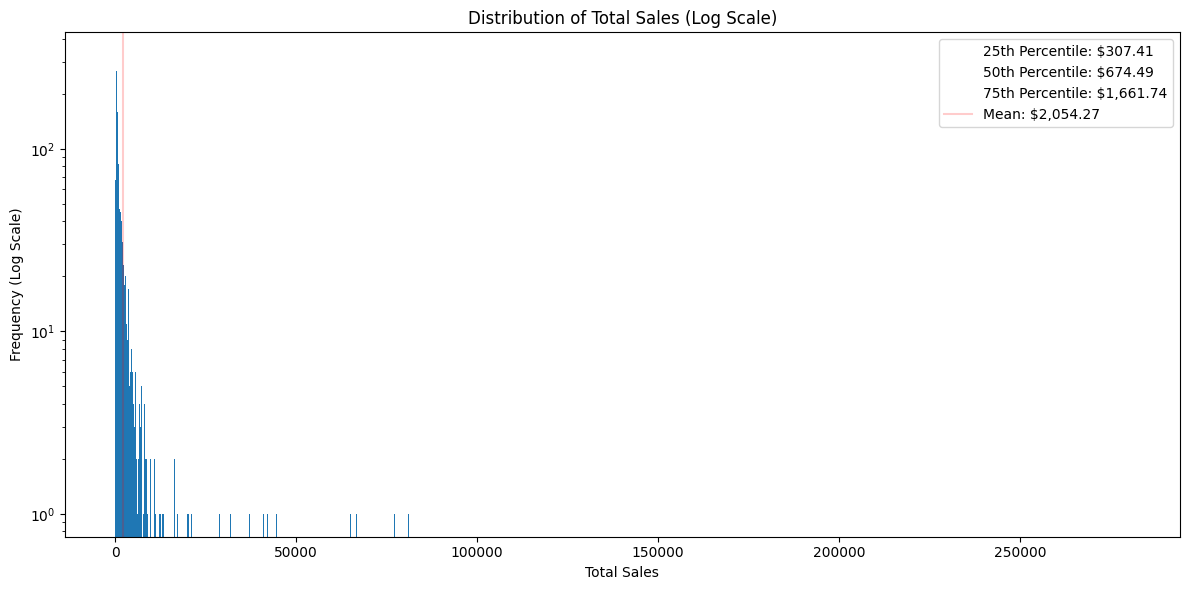

In [14]:
# Plot the distribution
plt.figure(figsize=(12, 6))
plt.hist(customer_level['TotalSales'], bins=len(customer_level))
plt.yscale('log')
plt.title('Distribution of Total Sales (Log Scale)')
plt.xlabel('Total Sales')
plt.ylabel('Frequency (Log Scale)')

# Plot quartiles
for q, value in quartiles_ts.items():
    plt.axvline(value, color='purple', linestyle='--', label=f'{int(q*100)}th Percentile: ${value:,.2f}', alpha=0)

# Plot mean
plt.axvline(mean_ts, color='red', linestyle='-', label=f'Mean: ${mean_ts:,.2f}', alpha=0.2)

plt.legend()
plt.tight_layout()
plt.show()

This highlights the biggest issue with the average method: it returns a single value that can easily be skewed by outlier customers that spend a ton or barely any at all. We need a better method: one that calculates LTV for multiple subsets of customers. Enter the cohort method.

## Cohort Method

Instead of lumping all customers together into one group, let's segment them into multiple groups and calculate a distinct LTV for each. This idea assume that customers in a group (cohort) share some trait that leads them to spend similarly. A common method is to create cohorts based on the date the customer first purchased, typically by month. In reality, the best choice for cohort delineation will depend on seasonality, what customer data is available, and the nature of the business. In this case, we'll try the common method of creating cohorts for each month.

### Prepping the Data

In [15]:
customer_level_cohort = ltv_features.groupby('CustomerID').agg({'InvoiceDate': lambda x: x.min().month,
                                                                'InvoiceNo': lambda x: len(x),
                                                                'TotalSales': lambda x: sum(x)})
customer_level_cohort.columns = ['StartMonth', 'PurchaseFrequency', 'TotalSales']
customer_level_cohort.head()

,StartMonth,PurchaseFrequency,TotalSales
CustomerID,,,
12346.0,1,1,77183.60
12347.0,12,182,4310.00
12348.0,12,31,1797.24
12349.0,11,73,1757.55
12350.0,2,17,334.40


In [16]:
customer_level_cohort.describe()

,StartMonth,PurchaseFrequency,TotalSales
count,4338.000000,4338.000000,4338.000000
mean,6.963808,91.720609,2054.266460
std,3.980623,228.785094,8989.230441
min,1.000000,1.000000,3.750000
25%,3.000000,17.000000,307.415000
50%,7.000000,41.000000,674.485000
75%,11.000000,100.000000,1661.740000
max,12.000000,7847.000000,280206.020000


Now that we have customers organized by the month they first purchased, let's calculate LTV for each cohort

### Calculate Cohort LTV

In [17]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_cohort_ltvs = []

for month_idx in range(1, 13):
    # Get all customers who started in month_idx
    customer_cohort = customer_level_cohort[customer_level_cohort['StartMonth'] == month_idx]
    average_sales = round(np.mean(customer_cohort['TotalSales']), 4)
    purchase_frequency = round(np.mean(customer_cohort['PurchaseFrequency']), 4)
    repeat_customer_count = customer_cohort[customer_cohort['PurchaseFrequency'] > 1].shape[0]
    churn_rate = round(1 - (repeat_customer_count / customer_cohort.shape[0]), 4)

    current_ltv = round((average_sales * purchase_frequency / churn_rate) * profit_margin, 2)
    monthly_cohort_ltvs.append(current_ltv)

cohort_ltv_df = pd.DataFrame(zip(months, monthly_cohort_ltvs), columns=['Month', 'LTV'])
for cohort in cohort_ltv_df.itertuples():
    print(f"{cohort.Month} cohort LTV: ${cohort.LTV:,.2f}")

Jan cohort LTV: $6,443,831.07
Feb cohort LTV: $1,780,555.18
Mar cohort LTV: $2,918,409.70
Apr cohort LTV: $1,575,393.96
May cohort LTV: $838,114.33
Jun cohort LTV: $2,340,688.84
Jul cohort LTV: $404,930.74
Aug cohort LTV: $905,033.45
Sep cohort LTV: $1,110,964.89
Oct cohort LTV: $617,331.39
Nov cohort LTV: $289,482.69
Dec cohort LTV: $20,803,933.73


Now we have 12 LTVs, one for each cohort. Notice the range: a min of $289k, and a max of $20.8m! Judging by the wildly high values in December and January, it appears that many of our high-value customers first purchased in those two months. This seems appropriate given that December-January is considered the Christmas/New Year's holiday season, when retailers are most likely to purchase stock in bulk from gift manufacturers like our business here. 

However, we want to be even more accurate and calculate a unique LTV for each customer. Enter the BG/NBD + GG method.

## BG/NBD + GG Method

BG/NBD + GG stands for "Beta Geometric/Negative Binomial Distribution with Gamma Gamma extension". BG/NBD is a widely used probabilistic model that predicts customer purchase behavior based on historical transaction. With the Gamma Gamma extension, we can convert purchase behavior to a lifetime monetary value.

The BG/NBD model has 3 key assumptions:
1. Purchase process: Each customer has a Poisson purchase rate, which varies across the population and follows a Gamma distribution
2. Churn process: Each customer has a probabilty of churning after a purchase, which follows a Beta distribution
3. Customer behavior: Customers are indendent of each other and do not affect one another's purchasing decisions

The BG/NBD model intakes customer x's purchase frequency (number of repeat purchases) and purchase recency (time since last purchase) as inputs. It combines those with the purchase rate and churn probability, and infers the likelihood that a customer will purchase again and when they will churn.

The GG extension goes beyond this to infer a monetary value. 

The GG extension assumes:
1. Each customer has an average transaction value, and each transaction amount randomly varies around the average according to a Gamma distribution
2. Average transaction value varies across customers, but does not vary over time for a given customer
2. Monetary value of a transaction is independent of purchase frequency

There's a ton of math and a lot of hyperparameters under the hood here, and it gets quite complicated. Lucky for us, there's a Python package called `Lifetimes` which handles everything for us.

### Prepping the Data

To tackle this method, we need to first create a summary table, composed of recency, frequency, and monetary value columns. This would normally require a lot of reformatting and coercing, but `Lifetimes` has a great utility function `summary_data_from_transactions_data` that will abstract this process for us! This func aggregates the transaction level data into customer level data, then calculates the frequency, recency, time duration, and monetary value for each customer. More precisely, this func calculates:\
- frequency: the number of repeat purchases
- recency: the time between the first and latest transaction
- T: the time between first purchase and end of the transaction period
- monetary_value: the mean of a customer's sales value

In [18]:
# pip install lifetimes
import lifetimes as lt
summary_data = lt.utils.summary_data_from_transaction_data(ltv_features, 'CustomerID', 'InvoiceDate', 'TotalSales')
summary_data.reset_index()
summary_data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


A customer with 0 in `frequency` and `recency` is a one-time purchaser--they did not make multiple purchases, therefore their `frequency` is 0. The `monetary_value` of these customers is assumed to be 0, because there is no indication that these customers will make repeat purchases. For all intents and purposes, these customers have already churned. In retail datasets like this, it's common to have a high ratio of one-time purchasers. In datasets based on subscription products, the ratio of one-time purchasers is typically lower due to the nature of a recurring subscription. Let's check how many one-time purchasers are in our dataset.

count    4338.000000
mean        2.864223
std         5.949000
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
----------------------------------------------
One-time purchasers: 35.68%


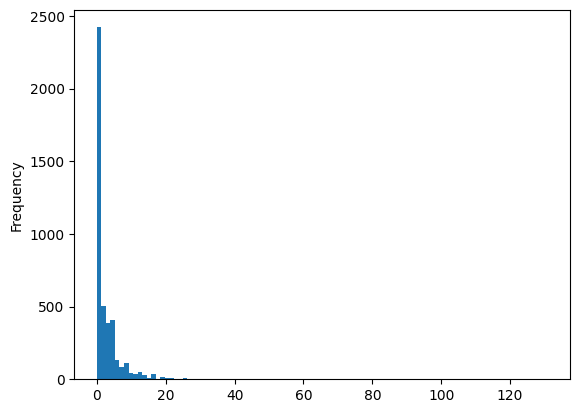

In [19]:
summary_data['frequency'].plot(kind='hist', bins=100)
print(summary_data['frequency'].describe())
print("----------------------------------------------")
one_time_purchasers = round(sum(summary_data['frequency'] == 0) / float(len(summary_data)) * 100, 2)
print(f"One-time purchasers: {one_time_purchasers}%")

Looks like the median frequency value is 1, which we can interpret as being a single-repeat-purchaser. 35.7% of our customers are one-time purchasers.\
Now that we know what the distribution of our data looks like, let's fit the BG/NBD model.

### Fit the Model

In [20]:
bgf_classifier = lt.BetaGeoFitter(penalizer_coef=0.0)
bgf_classifier.fit(summary_data['frequency'], summary_data['recency'], summary_data['T'])
bgf_classifier.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826542,0.026785,0.774044,0.879040
alpha,68.905121,2.611786,63.786020,74.024221
a,0.003437,0.010339,-0.016828,0.023702
b,6.745116,22.414725,-37.187745,50.677978


These summary values show the learned hyperparameter distributions. The model can now use these to predict future transactions and churn likelihood. To do this, we can use two convinient methods from `Lifetimes`:
1. `model.conditional_probability_alive()`: computes the probability that a customer with history (`frequency`, `recency`, `T`) is currently alive (IE not churned)
2. `plot_probability_alive_matrix(model)`: plots the relationships between frequency, recency, and the customer's 'alive likelihood'

            frequency  recency      T  monetary_value  probability_alive
CustomerID                                                              
12346.0           0.0      0.0  325.0        0.000000           1.000000
12347.0           6.0    365.0  367.0      599.701667           0.999698
12348.0           3.0    283.0  358.0      301.480000           0.999177
12349.0           0.0      0.0   18.0        0.000000           1.000000
12350.0           0.0      0.0  310.0        0.000000           1.000000
12352.0           6.0    260.0  296.0      368.256667           0.999406
12353.0           0.0      0.0  204.0        0.000000           1.000000
12354.0           0.0      0.0  232.0        0.000000           1.000000
12355.0           0.0      0.0  214.0        0.000000           1.000000
12356.0           2.0    303.0  325.0      269.905000           0.999478


<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

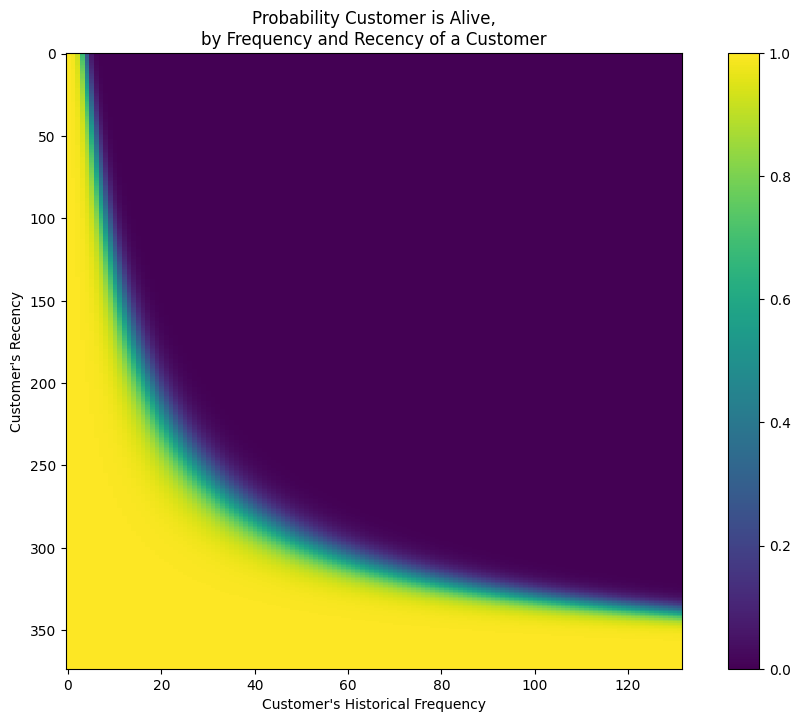

In [21]:
from lifetimes.plotting import plot_probability_alive_matrix
summary_data['probability_alive'] = bgf_classifier.conditional_probability_alive(summary_data['frequency'], 
                                                                                 summary_data['recency'], 
                                                                                 summary_data['T'])
print(summary_data.head(10))

alive_fig = plt.figure(figsize=(12, 8))
plot_probability_alive_matrix(bgf_classifier)

This is a complex graph, so let's break it down. The probabilty of a customer being alive is calculated based on the `recency` and `frequency` of that customer:
- If a customer has bought multiple times (`frequency`) and the time between first and most recent transactions is high (`recency`), then the probability of that customer being alive is high.
- Similarly, if a customer has a lower `frequency` (only purchased once or twice) and a low `recency` (time between first and most recent purchase), then the probability of that customer being alive is high.

The next thing we can do with this model is predict future transactions for the next `t` days for each customer:

In [22]:
t = 30
summary_data['pred_purchase_count'] = round(bgf_classifier.conditional_expected_number_of_purchases_up_to_time(t,
                                                                                                               summary_data['frequency'], summary_data['recency'], summary_data['T']), 2)
summary_data.sort_values(by='pred_purchase_count', ascending=False).head(10).reset_index()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_purchase_count
0,14911.0,131.0,372.0,373.0,1093.661679,0.999966,8.95
1,12748.0,112.0,373.0,373.0,301.024821,0.999971,7.66
2,17841.0,111.0,372.0,373.0,364.452162,0.999962,7.59
3,15311.0,89.0,373.0,373.0,677.729438,0.999964,6.10
4,14606.0,88.0,372.0,373.0,135.890114,0.999955,6.03
5,12971.0,70.0,369.0,372.0,159.211286,0.999926,4.82
6,13089.0,65.0,367.0,369.0,893.714308,0.999934,4.51
7,14527.0,53.0,367.0,369.0,155.016415,0.999925,3.69
8,13798.0,52.0,371.0,372.0,706.650962,0.999933,3.59
9,16422.0,47.0,352.0,369.0,702.472340,0.999567,3.27


We now have the predicted number of transactions each customer will make in the next `t` days.\
To do a quick sanity check, we can use a heuristic:
1. Let's take a random customer (CustomerID 12971). Over the course of 372 days, this customer purchased 70 times.
2. Thus, on average, the customer purchases 70/372 = 0.18817 items in a day. 
3. Multiply that by `t`, and we get 30 * 0.18817 = 5.6451 items purchased.

To abstract the heuristic, we have\
$Rough Purchase Estimate = (Frequency \div Recency) \times t$

We can then anecdotally evaluate how much of a difference there is between `pred_purchase_count` and RoughPurchaseEstimate. There will always be some amount of difference, caused by the underlying assumptions in the model--churn rate, Gamma and Beta distributions, etc.

### Calculate Monetary Value

Now that we've predicted future purchases, we can use the GG model to predict the monetary value. But before we can fit the GG model, we need to verify that the assumptions underlying the model hold true in our data. Of the 3 assumptions noted at the section header, only the 3rd (monetary value and purchase frequency are independent) can be verified. This can be easily checked by calculating the Pearson correlation. To check the correlation, we will only consider repeat customers, because one-time customers are already considered churned.

In [23]:
repeat_customers_summary = summary_data[summary_data['frequency'] > 0]
print(repeat_customers_summary.shape)
repeat_customers_summary.head()

(2790, 6)


,frequency,recency,T,monetary_value,probability_alive,pred_purchase_count
CustomerID,,,,,,
12347.0,6.0,365.0,367.0,599.701667,0.999698,0.47
12348.0,3.0,283.0,358.0,301.480000,0.999177,0.27
12352.0,6.0,260.0,296.0,368.256667,0.999406,0.56
12356.0,2.0,303.0,325.0,269.905000,0.999478,0.22
12358.0,1.0,149.0,150.0,683.200000,0.999486,0.25


In [24]:
# Calculate correlation between frequency and monetary value
repeat_customers_summary[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.015906
monetary_value,0.015906,1.000000


The correlation appears to be super weak. Thus, we can conclude that `frequency` and `monetary_value` are independent from eachother and we can fit the GG model to our data.

In [25]:
ggf_classifier = lt.GammaGammaFitter(penalizer_coef=0.001)
ggf_classifier.fit(repeat_customers_summary['frequency'], repeat_customers_summary['monetary_value'])
ggf_classifier.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,11.125568,0.269274,10.597792,11.653344
q,0.838782,0.019731,0.800110,0.877455
v,11.292978,0.281539,10.741162,11.844795


Now with our fitted GG model, we can predict the average profit for each transaction, enabling us to calculate LTV.

In [26]:
summary_data = summary_data[summary_data['monetary_value'] > 0]
summary_data['expected_avg_sales'] = ggf_classifier.conditional_expected_average_profit(summary_data['frequency'], 
                                                                                        summary_data['monetary_value'])
summary_data.head()

,frequency,recency,T,monetary_value,probability_alive,pred_purchase_count,expected_avg_sales
CustomerID,,,,,,,
12347.0,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247
12348.0,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889
12352.0,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926
12356.0,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534
12358.0,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679


In [27]:
# Checking the expected average value and the actual average value in the data to make sure the values are good
print(f"Predicted Average Sales: ${summary_data['expected_avg_sales'].mean():,.2f}")
print(f"Actual Average Sales: ${summary_data['monetary_value'].mean():,.2f}")

Predicted Average Sales: $486.91
Actual Average Sales: $477.38


The predicted values are pretty similar to the actual values, which means we can procede to calculating LTV.

There are 3 primary parameters in play here:
1. `time`: an int that represents the number of months in the future we're predicting into
2. `freq`: specifies the time unit our data is in. Daily = 'D', Monthly = 'M', etc
3. `discount_rate`: this is the same concept of discounted cash flow, where we discount monetary values by a discount rate to get the present value of that cash flow. The default is 0.01 monthly, which amounts to 12.7% annually.

With that in mind, we can predict the lifetime revenue `time` months in the future.

In [28]:
summary_data['pred_ltv'] = ggf_classifier.customer_lifetime_value(bgf_classifier, 
                                                                  summary_data['frequency'], 
                                                                  summary_data['recency'], 
                                                                  summary_data['T'], 
                                                                  summary_data['monetary_value'], 
                                                                  time=1, # months into the future
                                                                  discount_rate=0.01)
summary_data.head()

,frequency,recency,T,monetary_value,probability_alive,pred_purchase_count,expected_avg_sales,pred_ltv
CustomerID,,,,,,,,
12347.0,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247,280.409518
12348.0,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889,81.591026
12352.0,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926,206.034640
12356.0,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534,59.125290
12358.0,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679,174.550478


It's important to note that `pred_ltv` is a gross revenue value, rather than a profit value. To convert to a profit amount, we can use our `profit_margin` value from earlier.

In [29]:
print(f"Profit margin assumption: {profit_margin * 100:.2f}%")
summary_data['pred_ltv_profit'] = summary_data['pred_ltv'] * profit_margin
summary_data.head()

Profit margin assumption: 30.00%


,frequency,recency,T,monetary_value,probability_alive,pred_purchase_count,expected_avg_sales,pred_ltv,pred_ltv_profit
CustomerID,,,,,,,,,
12347.0,6.0,365.0,367.0,599.701667,0.999698,0.47,603.040247,280.409518,84.122855
12348.0,3.0,283.0,358.0,301.480000,0.999177,0.27,306.725889,81.591026,24.477308
12352.0,6.0,260.0,296.0,368.256667,0.999406,0.56,371.034926,206.034640,61.810392
12356.0,2.0,303.0,325.0,269.905000,0.999478,0.22,277.562534,59.125290,17.737587
12358.0,1.0,149.0,150.0,683.200000,0.999486,0.25,704.704679,174.550478,52.365143


In [30]:
summary_data['pred_ltv_profit'].describe()

count     2790.000000
mean        73.872242
std        295.964163
min          0.817228
25%         16.956392
50%         34.011484
75%         65.806409
max      10152.896419
Name: pred_ltv_profit, dtype: float64

And there we have it! LTV predicted for each customer. A marketing, SWAT case, or churn prevention team could use this info to target specific customers to increase their sales, prevent customers from churning, and ensure revenue stability.